# Project :- Creating a Review Classification Model for Gaming Company 

__We need to predict the customer sentiment for regarding , they will recommend the game to thier firends or not . we will analysis the customer feedback and predict user_suggestions.__

In [4]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy import displacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

In [5]:
# Download nltk resources 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\govinda.tak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\govinda.tak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Step 1 :- import the dataset 

In [7]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
validation_data=pd.read_csv('validation.csv')

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17877 entries, 0 to 17876
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17877 non-null  int64  
 1   title            17877 non-null  object 
 2   year             17698 non-null  float64
 3   user_review      17877 non-null  object 
 4   user_suggestion  17877 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 698.4+ KB


__here user_review is our feature and user_suggestion is our target . so we need to develop a model who can process the feature and predict the user suggestion.__

In [10]:
train_data.head(5)

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"Early Access ReviewVery great shooter, that ha...",1
1,2166,Tree of Savior (English Ver.),2016.0,I love love love playing this game!Super 100%!...,1
2,17242,Eternal Card Game,2016.0,Early Access ReviewAs a fan of MTG and Hearths...,1
3,6959,Tactical Monsters Rumble Arena,2018.0,Turn based strategy game similiar to FF Tactic...,1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,This game has an insanely huge download for be...,0


let's see testing data is balanced or not ....

<Axes: xlabel='user_suggestion', ylabel='Count'>

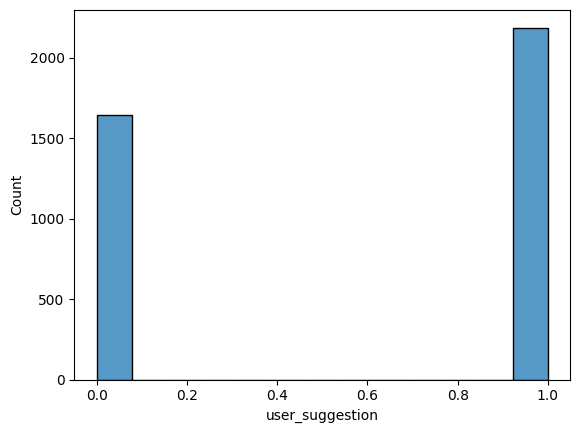

In [12]:
sns.histplot(data=test_data,x='user_suggestion')

so we can see our dataset is balanced .

# Step 2 :- Text Preprocessing 

In [15]:
# Load the spacy english model
# we are not using NER, we can disable it to speedup
nlp= spacy.load("en_core_web_sm")

__1) Preprocessing function__
lowercasing , stopword removal , punctuation and special char removal , lemmatization

In [17]:
def preprocess_text(texts):
    processed_texts=[]
    for doc in nlp.pipe(texts,n_process=-1):
    
        lemmatized_tokens=[token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
    
        processed_text=" ".join(lemmatized_tokens)
        processed_texts.append(processed_text)
     
    return processed_texts

In [18]:
train_data['user_review']=preprocess_text(train_data['user_review'])
test_data['user_review']=preprocess_text(test_data['user_review'])
validation_data['user_review']=preprocess_text(validation_data['user_review'])

__2) Vectorization__

In [20]:
tfidf_vectorizer=TfidfVectorizer(min_df=0.001,ngram_range=(1,3))

In [21]:
train_vector=tfidf_vectorizer.fit_transform(train_data['user_review'])
val_vector=tfidf_vectorizer.transform(validation_data['user_review'])
test_vector=tfidf_vectorizer.transform(test_data['user_review'])

In [22]:
type(train_vector)

scipy.sparse._csr.csr_matrix

In [23]:
print(train_vector)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 920557 stored elements and shape (17877, 8154)>
  Coords	Values
  (0, 1818)	0.10058359536531872
  (0, 36)	0.09935397540896894
  (0, 6326)	0.1550716497668653
  (0, 3395)	0.06368281210082341
  (0, 6604)	0.11713038556834933
  (0, 5124)	0.1836070116997505
  (0, 1348)	0.10978851173262537
  (0, 4964)	0.14758561835748343
  (0, 7605)	0.20335632868787432
  (0, 4621)	0.09044094434724426
  (0, 6606)	0.14614875407005062
  (0, 3478)	0.09448906145618478
  (0, 7804)	0.1286972475707798
  (0, 4368)	0.06781993763064816
  (0, 6001)	0.10006195153871675
  (0, 7235)	0.12488196117584537
  (0, 7271)	0.28104497402880285
  (0, 2544)	0.13326016219921372
  (0, 2042)	0.1437214158139473
  (0, 7084)	0.08985030274719866
  (0, 1609)	0.09015472347265582
  (0, 4870)	0.0661171735420133
  (0, 6814)	0.11639071980244761
  (0, 5865)	0.13547853918893416
  (0, 2270)	0.11448344439178523
  :	:
  (17875, 2513)	0.16292875643514532
  (17875, 4313)	0.18446011856767305
  (

__3) POS Tagging and NER__

In [25]:
def pos_ner_tagging(texts):
    pos_texts=[]
    ner_texts=[]
    for doc in nlp.pipe(texts,n_process=-1):
        pos_tag=[token.pos_ for token in doc]
        ner_tag=[token.ent_type_ if token.ent_type_ else "O" for token in doc]
        pos_text=" ".join(pos_tag)
        ner_text=" ".join(ner_tag)
        pos_texts.append(pos_text)
        ner_texts.append(ner_text)

    return [pos_texts,ner_texts]

In [26]:
pos_data,ner_data=pos_ner_tagging(train_data['user_review'])

In [27]:
train_data['pos_tag']=pos_data
train_data['ner_tag']=ner_data

In [28]:
train_data.head(5)

,review_id,title,year,user_review,user_suggestion,pos_tag,ner_tag
0,460,Black Squad,2018.0,early access reviewvery great shooter original...,1,ADJ NOUN NOUN ADJ ADJ NOUN NOUN PRON VERB ADJ ...,O O O O O O O PERSON O O O O O O O O O O O O O...
1,2166,Tree of Savior (English Ver.),2016.0,i love love love play lot class choose bound s...,1,PRON VERB NOUN NOUN VERB NOUN NOUN AUX VERB AD...,O O O O O O O O O O O O O O
2,17242,Eternal Card Game,2016.0,early access reviewas fan mtg hearthstone fun ...,1,ADJ NOUN VERB PROPN PROPN PROPN NOUN NOUN ADV ...,O O O O O O O O O O O O O O O O O O O O
3,6959,Tactical Monsters Rumble Arena,2018.0,turn base strategy game similiar ff tactics da...,1,VERB NOUN NOUN NOUN PROPN PROPN NOUN NOUN VERB...,O O O O O O O DATE O O O O O O O O O O O O O O...
4,8807,Yu-Gi-Oh! Duel Links,2017.0,game insanely huge download phone game blast v...,0,NOUN ADV ADJ NOUN NOUN NOUN NOUN NOUN ADJ NOUN...,O O O O O O O O O O O O O O O


In [29]:
# let's visulaize the NER -named entity relation tagging
text=train_data['user_review'][3]
doc=nlp(text)
displacy.render(doc,style="ent")

__Aplication of POS tagging__
because a noun never impact on our user review to predict user suggestion.
__so we can remove the noun from our user review dataset.__

In [31]:
def remove_noun(texts):
    without_noun=[]
    for doc in nlp.pipe(texts,n_process=-1):
        without_noun_tokens=" ".join([token.text for token in doc if token.pos_ not in ['NOUN','PROPN']])
        without_noun.append(without_noun_tokens)
    return without_noun    
    

In [32]:
train_data['filtered_user_review']=remove_noun(train_data['user_review'])

In [33]:
train_data.head(5)

,review_id,title,year,user_review,user_suggestion,pos_tag,ner_tag,filtered_user_review
0,460,Black Squad,2018.0,early access reviewvery great shooter original...,1,ADJ NOUN NOUN ADJ ADJ NOUN NOUN PRON VERB ADJ ...,O O O O O O O PERSON O O O O O O O O O O O O O...,early great shooter newbie understand mechanic...
1,2166,Tree of Savior (English Ver.),2016.0,i love love love play lot class choose bound s...,1,PRON VERB NOUN NOUN VERB NOUN NOUN AUX VERB AD...,O O O O O O O O O O O O O O,i love play choose bound storyline
2,17242,Eternal Card Game,2016.0,early access reviewas fan mtg hearthstone fun ...,1,ADJ NOUN VERB PROPN PROPN PROPN NOUN NOUN ADV ...,O O O O O O O O O O O O O O O O O O O O,early reviewas far good know great
3,6959,Tactical Monsters Rumble Arena,2018.0,turn base strategy game similiar ff tactics da...,1,VERB NOUN NOUN NOUN PROPN PROPN NOUN NOUN VERB...,O O O O O O O DATE O O O O O O O O O O O O O O...,turn remember easy enjoyable different try bor...
4,8807,Yu-Gi-Oh! Duel Links,2017.0,game insanely huge download phone game blast v...,0,NOUN ADV ADJ NOUN NOUN NOUN NOUN NOUN ADJ NOUN...,O O O O O O O O O O O O O O O,insanely huge entire far long need


# Step 3 :- Embeddings 

In [91]:
from gensim.models import Word2Vec
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
import torch.optim as optim

In [60]:
word2vec_model = Word2Vec(sentences=train_data.user_review.values.tolist(), #we train the model on corpus so model will create thier vocabulary.
                          vector_size=100, min_count=1 , workers=4)  #worker=4 -->4 worker thread will work. min_count=1-->if a word comes atleast 1 time it will include in vocabulary.

# Get vocabulary size
vocab_size=len(word2vec_model.wv)
print(vocab_size)

707


In [62]:
# Convert text to Word2Vec embeddings
def text_to_embeddings(text, word2vec_model, seq_length):
    embeddings = []
    
    for i, word in enumerate(text):
        if word in word2vec_model.wv:
            if i == seq_length:
                break
            embeddings.append(word2vec_model.wv[word])
        else:
            continue
        
    # Padding the sequences   
    if len(embeddings) < seq_length:
        zero_padding = [np.zeros(word2vec_model.vector_size) \
                        for _ in range(seq_length - len(embeddings))]    

        embeddings = embeddings + zero_padding

    return embeddings[:seq_length]   # it's work for truncate

# word2vec_model.vector_size gives the size of each word embedding (e.g., 300 for Word2Vec).
# np.zeros(word2vec_model.vector_size) creates a zero vector of the same size.
# The for loop runs for (seq_length - len(embeddings)) times, ensuring we create enough zero vectors to make the sequence the required length.

In [64]:
# Prepare data
def prepare_data(reviews, labels, word2vec_model):
    X = [text_to_embeddings(review, word2vec_model, 100) for review in reviews]
    X = [torch.tensor(embeddings, dtype=torch.float32) for embeddings in X]
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

In [70]:
# Prepare data
X_train, y_train = prepare_data(train_data.user_review, train_data.user_suggestion,
                    word2vec_model)

X_val, y_val = prepare_data(validation_data.user_review, validation_data.user_suggestion,
                    word2vec_model)

C:\Users\govinda.tak\AppData\Local\Temp\ipykernel_21688\5277148.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X = [torch.tensor(embeddings, dtype=torch.float32) for embeddings in X]


In [72]:
# Define hyperparameters
input_size = word2vec_model.vector_size
hidden_size = 128
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 30
batch_size = 64
dropout_rate = 0.5
leaky_relu_slope = 0.1


In [78]:
# Create DataLoader
train_data = TensorDataset(torch.stack(X_train), y_train) #torch.stack(X_train) converts this list of tensor into a single tensor, making it easier to work with PyTorch's TensorDataset and DataLoader.
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [80]:
# Create DataLoader
val_data = TensorDataset(torch.stack(X_val), y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Step 4 :- modeling by RNN MOdel with word embedding

In [83]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Basic RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.leaky_relu = nn.LeakyReLU()  # Leaky ReLU activation layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation layer

    def forward(self, x):
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # RNN output
        out, _ = self.rnn(x, h0)   # out → The output of all time steps.  _ → The final hidden state (not needed in this case, so we ignore it using _).
        # Apply Leaky ReLU to the outputs of the RNN layer
        out = self.leaky_relu(out)
        out = self.dropout(out)
        # Get the last sequence output for classification
        out = out[:, -1, :]        # out has shape (batch_size, sequence_length, hidden_size). 🔹 out[:, -1, :] selects the last time step's output (i.e., sequence_length - 1), which is often used for classification tasks.
        # Apply the linear layer for the final output
        out = self.fc(out)
        # Apply the sigmoid activation
        out = self.sigmoid(out)
        return out


In [93]:
# Initialize model, loss function, and optimizer
model = SentimentRNN(input_size, hidden_size, output_size, dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [95]:
def calculate_accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total



__Train the model__

Epoch 1/30, Loss: 0.6869, Val Loss: 0.6854
Epoch 2/30, Loss: 0.6847, Val Loss: 0.6840
Epoch 3/30, Loss: 0.6838, Val Loss: 0.6845
Epoch 4/30, Loss: 0.6902, Val Loss: 0.6849
Epoch 5/30, Loss: 0.6873, Val Loss: 0.6861
Early stopped at 5
Lowest Validation Loss: 0.6840 at Epoch 2


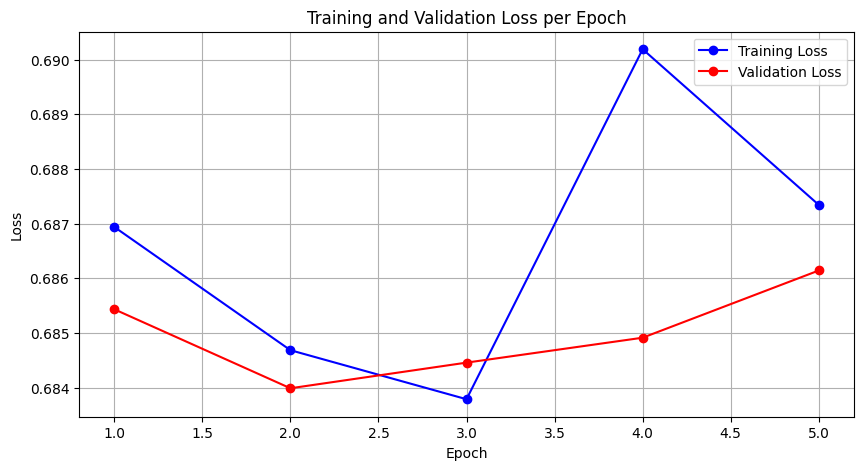

Best Model Training Accuracy: 56.72092632992113%
Best Model Validation Accuracy: 56.8780997128687%


In [98]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 3  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'rnn_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('rnn_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')